<a href="https://colab.research.google.com/github/AlexanderHi/Coursera_Capstone/blob/master/Clustering_neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Task 1

In [1]:
# Scrape table from url
import pandas as pd
import numpy as np

df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
...,...,...,...
175,M5Z,Not assigned,NaN
176,M6Z,Not assigned,NaN
177,M7Z,Not assigned,NaN
178,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...


In [2]:
# Remove rows with boroughs that are not assigned
df.drop(df.index[df['Borough'] == 'Not assigned'], inplace=True)
df

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
...,...,...,...
160,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,Business reply mail Processing CentrE
169,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...


In [3]:
# Check for and deal with NaNs in the Neighboorhood column
for _, row in df.iterrows():
  if row["Neighborhood"] == "NaN":
    row["Neighborhood"] = row["Borough"]
df

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
...,...,...,...
160,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,Business reply mail Processing CentrE
169,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...


In [4]:
df.shape

(103, 3)

# Task 2


In [0]:
# Read geo coords
geo_data = pd.read_csv("Geospatial_Coordinates.csv")
geo_data.rename(columns={"Postal Code": "Postal code"}, inplace=True)

In [27]:
# Merge dfs
df = pd.merge(df, geo_data, on="Postal code")
df.drop(columns=["Latitude_x", "Latitude_y", "Longitude_x", "Longitude_y"], inplace=True)
df

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558
101,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.636258,-79.498509


# Task 3

In [64]:
# Strip df to only contain boroughs in Toronto
df = df[df.Borough.str.contains("Toronto", na=False)]
df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [89]:
# Print map with all neighborhoods
lat_start = df.at[4, "Latitude"]
long_start = df.at[4, "Longitude"]

import folium
map = folium.Map(location=[lat_start, long_start], zoom_start=12)

for _, row in df.iterrows():
  lat = row["Latitude"]
  long = row["Longitude"]
  popup = row["Neighborhood"]
  #print("Lat: {}, Long: {}, Neighborhood: {}".format(lat, long, popup))
  c = folium.Circle(
        location=[lat, long],
        popup=popup,
        radius=300,
        color='crimson',
        fill=True,
        fill_color='crimson'
    ).add_to(map)
map

In [87]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN
epsilon = 0.015 # radius of cluster
minimumSamples = 3 # minimum number of data points do create a cluster
X = df[["Latitude", "Longitude"]].values
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_
unique_labels = set(labels)
print("labels: ", labels)
print("unique_labels: ", unique_labels)

labels:  [-1  0  0  0 -1  0  0 -1  0 -1  0 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1 -1 -1
  0 -1 -1  0 -1  0  0  0 -1  0  0 -1  0  0 -1]
unique_labels:  {0, -1}


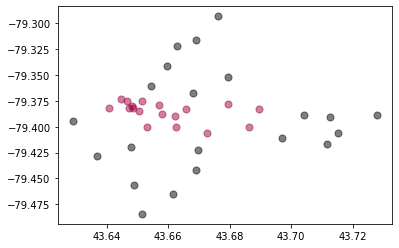

In [86]:
# Plot clusters
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

# Create mask to determine outliers (False==Outlier)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    a1 = plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = X[class_member_mask & ~core_samples_mask]
    a2 = plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)